# Change Point Analysis of Markov Switching Models
###### Ethan Goolish - December 19, 2019

# Import Needed Packages

In [1]:
#import needed packages

import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
import time
%matplotlib inline

# Markov Chain Time Series Generator + Examples

In [2]:
# P is the (k x k) transition matrix
# S is the vector of averages for each state (of length k)
# sigma is the shared variance
# n is the number of points to generate (length of time series)
# if debug = True, return state_gen rather than time_series.
def mkv_to_ts(P, S, sigma = 1, n = 10000, debug=False):
    k = len(S)
    base_matrix = np.tile(S, (n, 1)).T
    noise_matrix = np.random.normal(0, sigma, (k, n))
    full_matrix = base_matrix + noise_matrix
    
    state_gen = np.empty(n, dtype = np.int32)
    state_gen[0] = 0
    for i in range(1, n):
        state_gen[i] = np.random.choice(k, p=P[state_gen[i-1]])
    return state_gen if debug else np.choose(state_gen, full_matrix)

In [3]:
# Define example parameters:

# Transition Probabilities:
# Entry (i, j) = P(S_{t+1} = j | S_t = i)
P = np.array([[0.95, 0.02, 0.03],
              [0.01, 0.95, 0.04],
              [0.03, 0.03, 0.94]])

# Emission Mean for each State
S = np.array([5, 0, -5])

Text(0, 0.5, 'y_t')

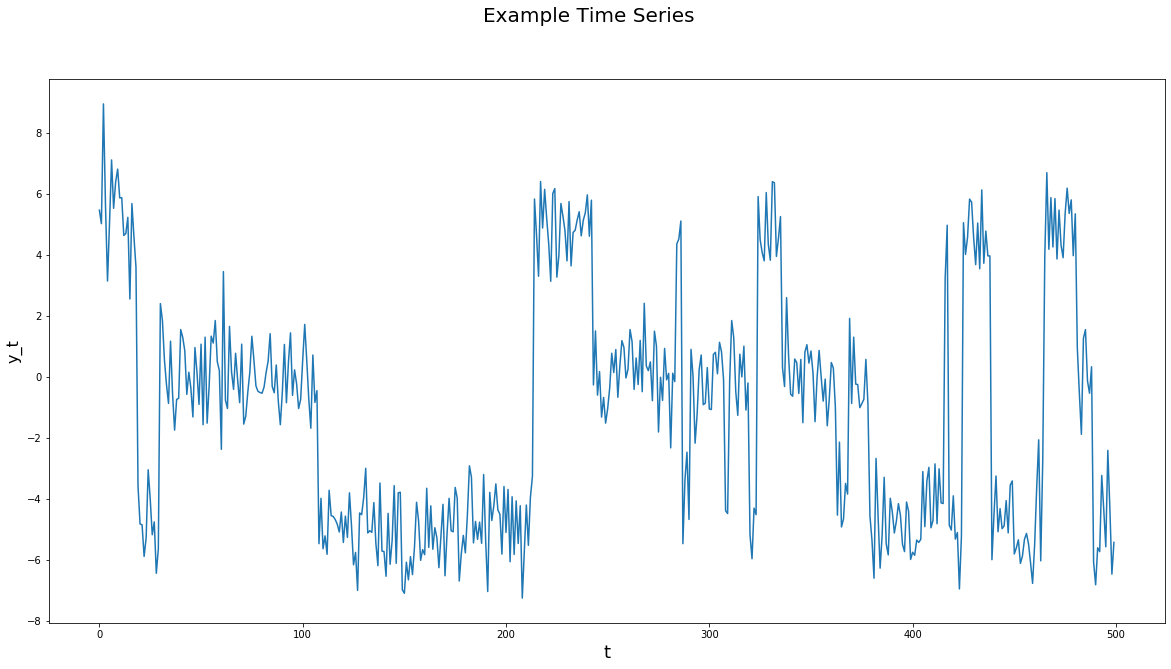

In [4]:
# generate time series and plot
ts = mkv_to_ts(P, S, n=500)
fig = plt.figure(figsize=(20,10))
plt.plot(ts)
fig.suptitle('Example Time Series', fontsize=20)
plt.xlabel('t', fontsize=18)
plt.ylabel('y_t', fontsize=16)


# Import e_divisive

In [5]:
# pip install git+https://github.com/egoolish/ecp_python
from ecp import e_divisive, e_agglomerative

# Define a MCTS and Run Basic e_divisive

Estimated Number of Change Points: 30.0
Minimum Size before Change: 2
Time:  2.0776138305664062
Found Change Points: 30


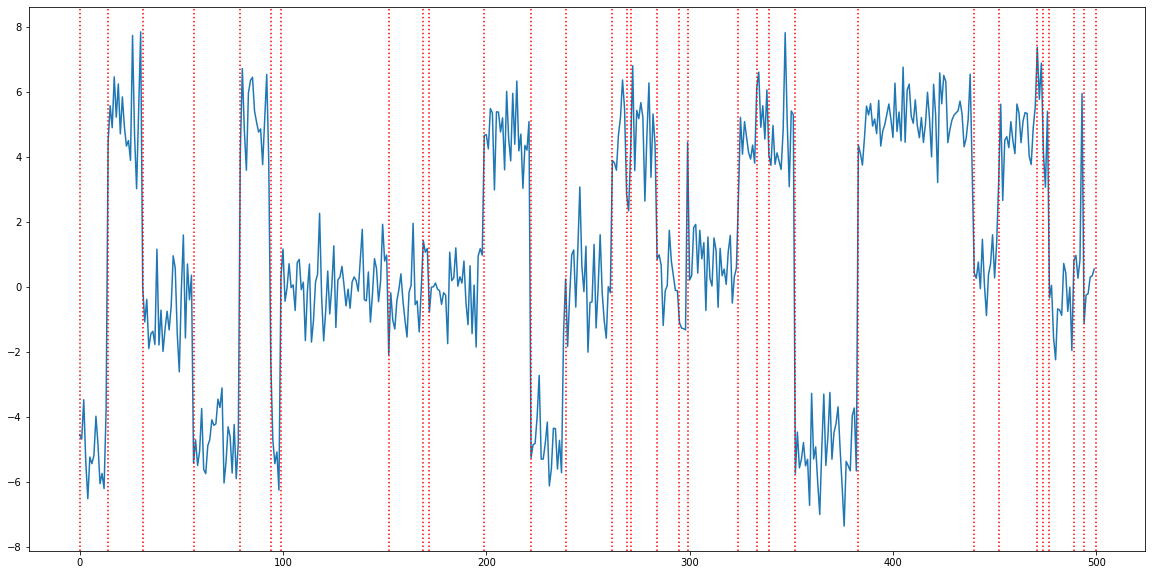

In [6]:
P = np.array([[0.95, 0.02, 0.03],
              [0.01, 0.95, 0.04],
              [0.03, 0.03, 0.94]])
S = np.array([-5, 0, 5])

N = 500
K = int(N/(1/(1 - P[0, 0]))) + N/100
ms = 2
num_of_states = len(S)

ts = mkv_to_ts(P, S, n=N)
plt.figure(figsize=(20,10))
plt.plot(ts)

t1 = time.time()
sol_dict = e_divisive.e_divisive(X = np.reshape(ts, (len(ts), 1)), k=K, alpha=2, min_size=ms)
t2 = time.time()
print("Estimated Number of Change Points: " + str(K))
print("Minimum Size before Change: " + str(ms))
print("Time: ", t2-t1)
print("Found Change Points: " + str(len(sol_dict['estimates'])-2))
for xc in sol_dict['estimates']:
    plt.axvline(x=xc, color='r', linestyle=':')

## New Agglomerative Method:

Recursively merges "closest" segments, then returns order of merging as well as final point state labels.

In [7]:
def get_within(alpha, X):
    alpha = float(alpha)
    ret = 0.0
    n = X.shape[0]

    Xprime = X.reshape(n, 1, X.shape[1])
    ret = np.sum(np.power(np.sqrt(np.einsum('ijk, ijk->ij', X-Xprime, X-Xprime)), alpha))
    return ret/(n*n)

def get_between(alpha, X, Y):
    alpha = float(alpha)
    ret = 0.0
    n = X.shape[0]
    m = Y.shape[0]

    X = X.reshape(X.shape[0], 1, X.shape[1])
    ret = np.sum(np.power(np.sqrt(np.einsum('ijk, ijk->ij', X-Y, X-Y)), alpha))
    return (2*ret)/float(n*m)



# alpha = alpha
# ts = ts
# n = len(sol_dict['estimates'])-1
# cluster = sol_dict['cluster']
# k = stopping condition (num_of_states)
def agglo_method(alpha, n, ts, cluster, k):
    ret = {"order": [], "cluster": cluster}
    curr_n = n
    if curr_n <= k:
        return ret
    
    within = np.zeros(n)
    for i in range(n):
        working_ts = ts[cluster==i]
        within[i] = get_within(alpha, np.reshape(working_ts, (len(working_ts), 1)))

    dflat = np.zeros(int(((n*n)-n)/2))
    idx = 0
    md = [] #maps from the linear index to the tuple (i, j) in the non-flattened distance matrix

    for i in range(n):
        for j in range(i+1, n):
            working_ts1 = ts[cluster==i]
            working_ts2 = ts[cluster==j]
            d = get_between(alpha, np.reshape(working_ts1, (len(working_ts1), 1)), np.reshape(working_ts2, (len(working_ts2), 1))) - within[i] - within[j]
            dflat[idx] = d
            idx += 1
            md.append((i, j))
    while(curr_n > k):
        min_idx = np.nanargmin(dflat)
        i, j = md[min_idx]
        ret["order"].append((i, j))
        
        
        cluster[cluster==j] = i
        working_ts = ts[cluster == i]
        new_within = get_within(alpha, np.reshape(working_ts, (len(working_ts), 1)))
        within[i] = new_within
        within[j] = new_within
        
        for idx in range(n):
            if idx != j and idx != i:
                working_ts1 = ts[cluster==i]
                working_ts2 = ts[cluster==idx]
                d = get_between(alpha, np.reshape(working_ts1, (len(working_ts1), 1)), np.reshape(working_ts2, (len(working_ts2), 1))) - within[i] - within[idx]
                
                if idx < i:
                    flat_idx = int(((2*idx*n) - (idx*idx) + (2*i) - (3*idx) - 2)/2)
                    dflat[flat_idx] = d
                elif idx > i:
                    flat_idx = int(((2*i*n) - (i*i) + (2*idx) - (3*i) - 2)/2)
                    dflat[flat_idx] = d
                    
                if idx < j:
                    flat_idx = int(((2*idx*n) - (idx*idx) + (2*j) - (3*idx) - 2)/2)
                    dflat[flat_idx] = np.inf
                elif idx > j:
                    flat_idx = int(((2*j*n) - (j*j) + (2*idx) - (3*j) - 2)/2)
                    dflat[flat_idx] = np.inf
            elif idx == j:
                t1, t2 = (i, j) if i < j else (j, i)
                flat_idx = int(((2*t1*n) - (t1*t1) + (2*t2) - (3*t1) - 2)/2)
                dflat[flat_idx] = np.inf  
                
                flat_idx = int(((2*t2*n) - (t2*t2) + (2*t1) - (3*t2) - 2)/2)
                dflat[flat_idx] = np.inf
        curr_n = len(np.unique(cluster))
    ret["cluster"] = cluster
    return ret

Runs New Agglomerative method, and then creates estimates of the change points based on where the labels change.

In [8]:
point_labels = agglo_method(alpha=2, n=len(sol_dict['estimates'])-1, ts=np.copy(ts), cluster=np.copy(sol_dict['cluster']), k=3)["cluster"]
final_ests = [sol_dict['estimates'][0]]
seg_labels = [point_labels[0]]
for i in range(1, len(point_labels)):
    if point_labels[i] != point_labels[i-1]:
        final_ests.append(i)
        seg_labels.append(point_labels[i])
final_ests.append(sol_dict['estimates'][-1])
final_ests = np.array(final_ests)
seg_labels = np.array(seg_labels)
print("State Labels for each Point: ")
print(point_labels)
print()
print("Segment Estimates: ")
print(final_ests)
print()
print("Segment Labels: ")
print(seg_labels)

State Labels for each Point: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2

/Users/ethangoolish/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


## Plots Segments with Labeled States

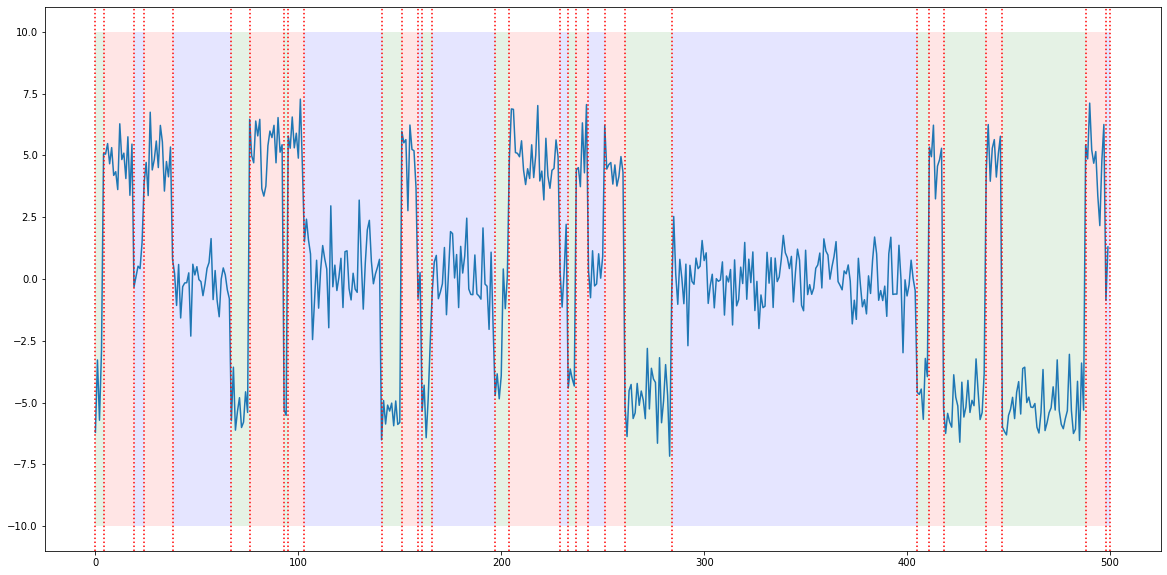

In [9]:
plt.figure(figsize=(20,10))
plt.plot(ts)
for xc in final_ests:
    plt.axvline(x=xc, color='r', linestyle=':')

diff_labs = np.unique(seg_labels)
for i in range(len(seg_labels)):
    if seg_labels[i] == diff_labs[0]:
        plt.fill_betweenx([-10, 10], final_ests[i], final_ests[i+1], facecolor='green', alpha=0.10)
    elif seg_labels[i] == diff_labs[1]:
        plt.fill_betweenx([-10, 10], final_ests[i], final_ests[i+1], facecolor='red', alpha=0.10)
    else:
        plt.fill_betweenx([-10, 10], final_ests[i], final_ests[i+1], facecolor='blue', alpha=0.10)

avg_time: for each state, find the length of an average stay in that state.

Use this to calculate P_{i, i} -- the probability of staying in the same state. This is P_diag

In [10]:
lens = np.diff(final_ests)
find_avg_time = np.vectorize(lambda x : np.mean(lens[seg_labels == x]))
avg_times = find_avg_time(np.unique(seg_labels))

print("Average length for each state before transitioning: ")
print(avg_times) #P_{i, i} = (x - 1)/x
print()
P_diag = np.vectorize(lambda x : (x - 1)/x)(avg_times)

print("Corresponding Probabilities: ")
print(P_diag)

Average length for each state before transitioning: 
[12.         11.63636364 26.66666667]

Corresponding Probabilities: 
[0.91666667 0.9140625  0.9625    ]


Count the total number of times we go from a state i to any other state.

Also count the number of times we go from a state i to a specific state j.

P_{i, j} is proportional to (# of times we go from i to j)/(# of times we go from i to any other state).

To calculate P_{i, j} exactly, see how much wiggle room we have (1 - P_{i, i}). Then fill up that wiggle room with a normalized version of the above ratio.

In [11]:
est_P = np.zeros((num_of_states, num_of_states))
for i in range(1, len(seg_labels)):
    est_P[seg_labels[i-1], seg_labels[i]] += 1
np.fill_diagonal(est_P, 0)
est_P = normalize(est_P, axis = 1, norm='l1')
est_P = (est_P.T*(1 - P_diag)).T
np.fill_diagonal(est_P, P_diag)
print("Estimated Transition Matrix: ")
print(est_P)

Estimated Transition Matrix: 
[[0.91666667 0.06818182 0.01515152]
 [0.03125    0.9140625  0.0546875 ]
 [0.028125   0.009375   0.9625    ]]


# Prints Comparison between Actual/Estimated P and S

Actual P: 
[[0.95 0.02 0.03]
 [0.01 0.95 0.04]
 [0.03 0.03 0.94]]
Estimated P: 
[[0.91666667 0.06818182 0.01515152]
 [0.03125    0.9140625  0.0546875 ]
 [0.028125   0.009375   0.9625    ]]

Point Labels: 
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 2 2 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 2 2 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

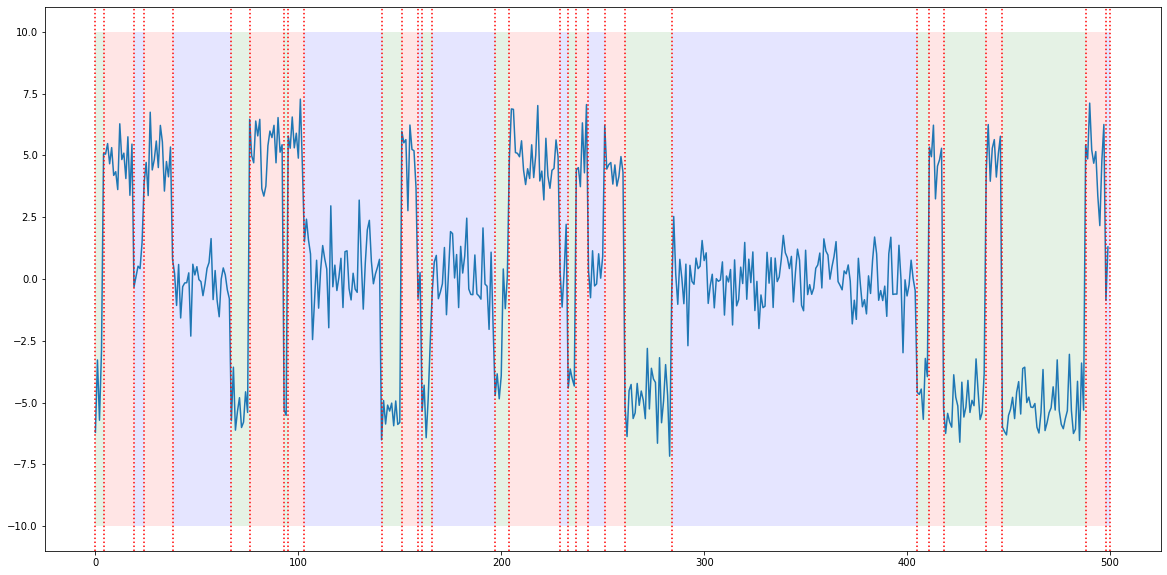

In [12]:
#Final Solution:
plt.figure(figsize=(20,10))
plt.plot(ts)
for xc in final_ests:
    plt.axvline(x=xc, color='r', linestyle=':')

diff_labs = np.unique(seg_labels)
for i in range(len(seg_labels)):
    if seg_labels[i] == diff_labs[0]:
        plt.fill_betweenx([-10, 10], final_ests[i], final_ests[i+1], facecolor='green', alpha=0.10)
    elif seg_labels[i] == diff_labs[1]:
        plt.fill_betweenx([-10, 10], final_ests[i], final_ests[i+1], facecolor='red', alpha=0.10)
    else:
        plt.fill_betweenx([-10, 10], final_ests[i], final_ests[i+1], facecolor='blue', alpha=0.10)

print("Actual P: ")
print(P)
print("Estimated P: ")
print(est_P)
print()
print("Point Labels: ")
print(point_labels)
print()
print("Segment Labels: ")
print(seg_labels)